In [7]:
import csv
import pandas as pd
import numpy as np
import itertools as it
from random import random
from collections import namedtuple
from scipy.optimize import minimize
from scipy import stats
from sklearn.metrics import confusion_matrix
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
import matplotlib.patches as patches
import seaborn as sns
import json
sns.set()
sns.set_style('white')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Reinforcement learning model

There is evidence that reinforcement learning is impaired in patients
suffering from major depressive disorder (see [Chen et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25979140/) for a review).

This section will focus on modelling behavioural impairments
during a probabilistic reversal learning task inspired by an article of [Dombrovski et al. (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3020386/).

## Experiment

The experiment was performed by 18 MDD patients and 35
healthy control participants matched for age, sex and IQ. In each trial of the experiment, participants were
asked to make a simple choice between two stimuli. Each stimulus had a certain probability of being followed by a reward (as opposed to no reward). The probabilities were unknown to participants and changed every
30 trials, switching between pairs of probabilities. The participants were unaware of these switches.

The paired probabilities were:
- $50\%$ for stimulus $A$ and $75 \%$ for stimulus $B$, and
- $75\%$ for stimulus $A$ and $25 \%$ for stimulus $B$.

The stimulus always appeared the same to participants, only the reward probability changed.

Participants were asked to maximize their reward over 240 trials.

## Model

The behaviour of participants will be modeled using a simple reinforcement learning model. The value
of the chosen stimulus $i$ will be updated on trial $t$ after observing reward $r$:

<center>
    $  V_t^i = V_t^i + \epsilon + (r_t - V_t^i) $
</center>

The initial $V$ values are set to 0. When the outcome of one stimulus choice is observed, the value of the
alternative option is not updated. 

The probability of choosing stimulus $A$ as opposed to stimulus $B$ on trial
$t$ is modelled using a softmax function

<center>
$P(\text{action } A | V_t) = \frac{\mathrm{exp}(V_t^A)}{\mathrm{exp}(V_t^A) + \mathrm{exp}(V_t^B)}$
</center>

Therefore, there are two parameters:

- the learning rate, $\epsilon$, and
- inverse temperature, $\beta$. 

We hypothesise that depression could be related to changes in reward learning
(i.e. an altered learning rate) or some change in decision making (inverse temperature)
    
##  Data structure and parsing

### Parsing the CSV

- Two files: `rewards.csv` and `choices.csv`
- Each row represents a participant. 
- First 18 rows are patients. 
- Last 35 rows are controls. 
- Each column represents a trial. (Row number $x$ represents participant $x$ in each file.)

Choices: 
- $1\to$ stimulus A and 
- $2 \to$ stimulus B

REWARDS: 
- $1 \to$ reward and 
- $2 \to$ no reward

### Data structure 

List of namedtuples with two fields:

- `choices`: list of the choices for each participant.
- `rewards`: list of the rewards for each participant.



In [20]:
class Behaviour(object):
    Person = namedtuple('Person', 'choices, rewards, Vs')
    
    plot_params = {
            'label_size': 14,
            'title_size': 20,
            'subplot_size': 16,
            'blue': '#40599B',
            'red': '#D97575',
            'gold': '#d4af37',

    }
    
    def __init__(self, model):
        self.probs = {0: [0.50, 0.75], 1: [0.75, 0.25]}
        self.probs_switch = 30 
        
        self.model = model
        self.V0 = [[0, 0], [0,0], [0.3, 0.1]][model]
        self.V_update_fns = [self._m0_update_V, self._m1_update_V, self._m0_update_V][model]
        self.probability_fns = [self._m0_probability, self._m1_probability, self._m0_probability][model]
        
        self.param1_str = 'Epsilon'
        self.param2_str = ['Beta', 'Rho', 'Beta'][model]
        
        self.fit_starting_params = [(0.5, 5), (0.5, 5.5), (0.5, 5)][model]
        
    @staticmethod
    def explore_parameters(model=0, ppts=100, eps=(0,1), beta=(1, 15), 
                           eps_size=10, beta_size=15, plot=True, 
                           interactive=False, save=False):
        """ Parameter exploration. 
        Returns a 3D showing the number of rewards for different learning
        rates and inverse temperature values.
        :param: model (int, default 0): which model to use. 
        :param: ppts (int, default 100): number of participants.
        :param: eps (tuple, default (0, 1)): range of learning rate
        :param: beta (tuple, default (1, 15)): range of inverse temperature (models 1 and 3),
                                               or reward sensitivity (model 2).
        :param: eps_size (int, default 10): number of learning rates to try.
        :param: beta_size (int, default 15): number of inverse temperatures / reward sensitivities
                                             to try.
        :param: plot (bool, default True)
        :param: interactive (bool, default False): whether to make the plot interactive.
                                                   only for jupyter notebooks, will probably
                                                   have to close after.
        :param: save (str, default False): name to save the figure.
        """
        # Get the parameters meshgrid
        params_eps, params_beta = Behaviour._get_params(eps, beta, 
                                                          eps_size, 
                                                          beta_size)
        # Initialise an empty rewards matrix
        rewards_out = np.zeros((eps_size, beta_size))
        
        for ind, _ in np.ndenumerate(rewards_out):
            params = [params_eps[ind], params_beta[ind]]
            # Simulate with the given parameters and calculate the rewards
            sim = Simulation(ppts, params, model=model)
            rewards_out[ind] = np.mean([np.sum(p.rewards) for p in sim.data])
        
        if plot:
            if interactive:
                # The interactive plot
                %matplotlib notebook
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                plot = ax.plot_surface(params_beta, params_eps, 
                                       rewards_out, cmap='YlOrBr')
            else:
                # The regular plot
                fig = plt.figure(figsize=(20,7))
                ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                plot1 = ax1.plot_surface(params_beta, params_eps, 
                                         rewards_out, cmap='YlOrBr')
                ax2 = fig.add_subplot(1, 2, 2, projection='3d')
                plot2 = ax2.plot_surface(params_eps, params_beta, 
                                         rewards_out, cmap='YlOrBr')    
                fig.colorbar(plot1, shrink=0.5)
                
                if model == 1:
                    eps_str, beta_str = 'learning rate', 'reward sensitivity'
                else:
                    eps_str, beta_str = 'learning rate', 'inverse temperature'
                fig.suptitle(f"""Total rewards for each {eps_str}, {beta_str} pair 
                for a simulation ran {ppts} times.""", 
                             fontsize=Behaviour.plot_params['title_size'])
                ax1.set_title('Angle 1', 
                              fontsize=Behaviour.plot_params['subplot_size'])
                ax2.set_title('Angle 2', 
                              fontsize=Behaviour.plot_params['subplot_size'])
                ax1.set_xlabel(f'{beta_str}', fontsize=Behaviour.plot_params['label_size'])
                ax1.set_ylabel(f'{eps_str}', fontsize=Behaviour.plot_params['label_size'])
                ax1.set_zlabel(f'Rewards', fontsize=Behaviour.plot_params['label_size'])
                
                ax2.set_ylabel(f'{beta_str}', fontsize=Behaviour.plot_params['label_size'])
                ax2.set_xlabel(f'{eps_str}', fontsize=Behaviour.plot_params['label_size'])
                ax2.set_zlabel(f'Rewards', fontsize=Behaviour.plot_params['label_size'])
                
                if save:
                    plt.savefig(f'figures/{save}.pdf', format='pdf')
                    
            max_indices = (np.int(np.argmax(rewards_out, axis=0)[0]), 
                          np.int(np.argmax(rewards_out, axis=1)[0]))
            print(f'Maximum reward corresponds to: ')
            print(f'  - {beta_str}: {params_beta[max_indices]}')
            print(f'  - {eps_str}: {params_eps[max_indices]}')
    
    # Helper function for explore_parameters
    @staticmethod
    def _get_params(eps, beta, eps_size, beta_size):
        """ Helper of explore_parameters.
        :param: eps (tuple): range of the first parameter
        :param: beta (tuple): range of the second parameter
        :param: eps_size (int): number of values for the first parameter.
        :param: beta_size (int): number of values for the second parameter.
        :returns: a transposed numpy meshgrid with the linear spaces of both parameters.
        """
        eps_space = np.linspace(eps[0], eps[1], num=eps_size)
        beta_space = np.linspace(beta[0], beta[1], num=beta_size)
        xx, yy = np.meshgrid(eps_space, beta_space)
        return xx.T, yy.T

    def neg_log_likelihood(self, params, person_ind):
        """ Compute the negative log likelihood for a participant given 
        a set of parameters.
        :param: params (tuple): parameters to use. 
        :param: person_ind (int): participant index.
        :returns: negative log likelihood
        """
        eps, beta = params[0], params[1]
        
        # The learning rate cannot be negative or bigger than 1 by defintion
        if eps < 0: eps = 0
        if eps > 1: eps = 1
        person, V = self.data[person_ind], self.V0[:]
        likelihoods = []
        for ind, choice in enumerate(person.choices):
            # Getting the indev of the choice for V
            choice_ind = choice - 1
            # Getiing the index of the other choice
            choice_ind_alt = int(choice_ind == 0)
            # Computing the probability of the choice with the appropiate model
            P_choice = self._probability(*[V, beta, choice_ind, choice_ind_alt])
            # Updating V with the appropiate model
            V = self._update_V(*[V, choice_ind, eps, beta, person.rewards[ind]])
            likelihoods.append(P_choice)
        return -np.sum(np.log(likelihoods))

    
    def _update_V(self, *args):
        """ Call the appropiate update_V function for the model.
        """
        return self.V_update_fns(*args)
    
    def _probability(self, *args):
        """ Call the appropiate probability function for the model
        """
        return self.probability_fns(*args)
    
    def _m0_probability(self, V, beta, choice_ind, choice_ind_alt):
        """ Probability for the model 0.
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): inverse temperature
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: probability
        """
        return (np.exp(beta * V[choice_ind]) / (np.exp(beta * V[choice_ind]) + 
                                                np.exp(beta * V[choice_ind_alt])))
    
    def _m1_probability(self, V, beta, choice_ind, choice_ind_alt):
        """ Probability for the model 1
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): not used here.
        :param: choice_ind (int): V index of the choice made
        :returns: probability
        """
        return np.exp(V[choice_ind]) / (np.exp(V[choice_ind]) + np.exp(V[choice_ind_alt]))
        
    def _m0_update_V(self, V, choice_ind, eps, beta, reward):
        """ Update V for model 0
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): not used here.
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: updated reinforcement learning values
        """
        V[choice_ind] = V[choice_ind] + eps * (reward - V[choice_ind])
        return V
    
    def _m1_update_V(self, V, choice_ind, eps, rho, reward):
        """ Update V for model 1
        :param: V (tuple): current reinforcement learning values
        :param: rho (float): reward sensitivity.
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: updated reinforcement learning values
        """
        V[choice_ind] = V[choice_ind] + eps * (rho * reward - V[choice_ind])
        return V
    
    def fit_model(self):
        """ Fit the model to data to find the best-fit parameters
        for each participant.
        :returns: eps_out (list): best-fit learning rate.
                  beta_out (list): best-fit neg-energy / reward-sens.
                  success_out (list): whether it succeeded for each ppt.
        """
        eps_out, beta_out, success_out = [], [], []
        starting_params = self.fit_starting_params[:]
        for ind, _ in enumerate(self.data):
            # Using scipy.minimize with BFGS option
            opt = minimize(self.neg_log_likelihood, starting_params, 
                           args=(ind), method='BFGS')
            eps_out.append(opt.x[0])
            beta_out.append(opt.x[1])
            success_out.append(opt.success)
        
        return eps_out, beta_out, success_out
    
    @staticmethod
    def parameter_recovery(ppts, model=0, num=53, plot=True, save=(False, False)):
        """ Perform parameter recovery.
        Simulate 53 sets of data with 53 random pairs of parameters, 
        then find the best-fit parameters and report the statistics.
        :params: ppts (int): number of participants for each simulation
        :params: model (int, default 0): which model to use
        :params: num (int, default 53): amount of data-sets to collect
        :params: plot (bool, default True)
        :param: save (tuple, default False): (name of plot 1, name of plot 2)
        """
        params_list = Behaviour._get_params_from_normal(num=num)
        eps_list = list(map(lambda x: x[0], params_list))
        beta_list = list(map(lambda x: x[1], params_list))

        sim = [Simulation(ppts, p, model=model, trials=120) 
                for p in params_list]

        fit_params = [s.fit_model() for s in sim]
        
        eps_fit = list(map(lambda x: np.mean(x[0]), fit_params))
        beta_fit = list(map(lambda x: np.mean(x[1]), fit_params))
                        
        if plot:
            # Plot the starting parameters distribution
            Behaviour._plot_params_recovery(eps_list, beta_list, save[0])
            # Plot the parameter recovery
            Behaviour._plot_parameter_recovery(eps_list, beta_list, 
                                               eps_fit, beta_fit, save[1])

        r_eps = stats.pearsonr(eps_list, eps_fit)
        r_beta = stats.pearsonr(beta_list, beta_fit)
        
        print(f'{sim[0].param1_str}: {r_eps}')
        print(f'{sim[0].param2_str}: {r_beta}')
        
    @staticmethod
    def _get_params_from_normal(num=53, eps=(0.35, 0.01), beta=(5.5, 0.5)):
        """ Helper method for parameter_recovery.
        Get random parameters from a normal distribution given means and standard deviations.
        """
        return [[np.random.normal(eps[0], eps[1]), np.random.normal(beta[0], beta[1])] 
                for _ in range(num)]    
        
    @staticmethod
    def _plot_parameter_recovery(eps_list, beta_list, eps_fit, beta_fit, save=False):
        """ Helper function for parameter_recovery to illustrate the relation between the
        fit and the starting parameters.
        Calculates the lines of best fit
        """
        
        # Getting the best fit line for the first parameter
        eps_best_fit = np.polyfit(eps_list, eps_fit, 1)
        eps_best_fit_fn = np.poly1d(eps_best_fit)
        eps_best_fit_x = np.linspace(np.min(eps_list), np.max(eps_list), num=10)
        
        # Getting the best fit line for the second parameter
        beta_best_fit = np.polyfit(beta_list, beta_fit, 1)
        beta_best_fit_fn = np.poly1d(beta_best_fit)
        beta_best_fit_x = np.linspace(np.min(beta_list), np.max(beta_list), num=10)
        
        fig, axs = plt.subplots(1, 2, figsize=(13, 4))
        axs[0].scatter(eps_list, eps_fit, color=Behaviour.plot_params['red'])
        axs[0].plot(eps_best_fit_x, eps_best_fit_fn(eps_best_fit_x), 
                    color=Behaviour.plot_params['gold'])
        axs[1].scatter(beta_list, beta_fit, color=Behaviour.plot_params['blue'])
        axs[1].plot(beta_best_fit_x, beta_best_fit_fn(beta_best_fit_x), 
                    color=Behaviour.plot_params['gold'])
        axs[0].set_yticks(np.linspace(0.2, 0.6, num=10))
        fig.suptitle('Relationship between starting parameters and best fit parameters', 
                     fontsize=Behaviour.plot_params['title_size'])
        axs[0].set_xlabel('Starting learning rate', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel('Best-fit learning rate', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_xlabel('Starting inverse temperature', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_ylabel('Best-fit inverse temperature', fontsize=Behaviour.plot_params['label_size'])
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
                
    @staticmethod
    def _plot_params_recovery(eps_list, beta_list, save=False):
        """ Helper function for parameter_recovery to illustrate the distribution of the starting parameters.
        """
        num = range(len(eps_list))
        fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
        axs[0].hist(eps_list, color=Behaviour.plot_params['red'], bins=15)
        axs[1].hist(beta_list, color=Behaviour.plot_params['blue'], bins=15)
        fig.suptitle('Parameters randonmly sampled from a normal distribution', 
                     fontsize=Behaviour.plot_params['title_size'])
        axs[0].set_xlabel('Learning rate (epsilon)', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel('Count', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_xlabel('inverse temperature (beta)', fontsize=Behaviour.plot_params['label_size'])
        
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
    
    @staticmethod
    def model_comparison(models=False):
        """ Perform model comparison.
        Fit the data to all of the models. For each model, compute
        the AIC and BIC scores.
        :return: two lists [score_m0, score_m1, score_m2]
        """
        all_NLLs = []
        out = {}
        nan_indices = []
        if not models:
            models = RealData(model=0), RealData(model=1), RealData(model=2)
        
        for model in models:  # For all models
            # Find the best-fit parameters
            eps_out, beta_out, success = model.fit_model()
            NLLs = []
            # Find the NLL for all participants
            for i, _ in enumerate(model.data):
                NLL = model.neg_log_likelihood((eps_out[i], beta_out[i]), i)
                if np.isnan(NLL):
                    nan_indices.append(i)
                NLLs.append(NLL)
            all_NLLs.append(NLLs)
        # Filter out the nan values    
        filt_NLLs = Behaviour._filter_model_comparison(all_NLLs, nan_indices)
        # Calculate and return AIC and BIC scores.
        for m, NLLs in enumerate(filt_NLLs):
            out[m] = {'AIC': Behaviour.get_AIC(NLLs), 
                      'BIC': Behaviour.get_BIC(NLLs, len(models[0].data[0].choices))}
        return out
    
    @staticmethod
    def get_AIC(NLLs, p=2):
        """ Compute AIC score """
        return 2 * np.sum(NLLs) + 2 * p * len(NLLs)
    
    @staticmethod
    def get_BIC(NLLs, n, p=2):
        """ Compute BIC score """
        return 2 * np.sum(NLLs) + (p * n * len(NLLs))
    
    @staticmethod
    def _filter_model_comparison(all_NLLs, nan_indices):
        """Filter the participants for which the NLL could not be computed.
        Filtering is done in the data for all models.
        :param: temp (dict): dictionary with the unfiltered data
        :param: overflow_indices (list): indices of participants 
                                         that could not be computed
        """
        
        out = []
        for NLLs in all_NLLs:
            out.append(list(filter(lambda x: NLLs.index(x) not in nan_indices, NLLs)))
        
        return(out)
    
    @staticmethod
    def model_recovery(ppts=53, trials=20):
        
        predicted, real = [], []
        
        # For all models
        for model_number in range(3):
            # The real value is the model that generated the data
            real += [model_number] * trials
            
            for _ in range(trials):
                # Get the best-fit model
                predicted.append(Behaviour._winner_model(ppts, model_number))
                
        # Return a confusion matrix
        return confusion_matrix(real, predicted)
                            
                
    @staticmethod
    def _winner_model(ppts, model_number):
        """ Get the winner of:
            - Simulating a data-set using a model
              with parameters coming randomly from a Gaussian.
            - Finding the best-fit parameters to the data using 
              the three models.
            - The winner is the one with the lowest AIC/BIC score
        """
        # Means and stds for each model to get random parameters
        starting= [((0.35, 0.01), (5.5, 0.5)), 
                   ((0.30, 0.01), (6.0, 0.5)), 
                   ((0.35, 0.01), (5.5, 0.5))]
        
        # Get the random parameters from the Gaussian
        params = Behaviour._get_params_from_normal(num=1, eps=starting[model_number][0], 
                                                   beta=starting[model_number][1])[0]
        
        # Simulate the data
        model = Simulation(ppts, params, model=model_number)
        # Fit the three models to the data
        fit_params = Behaviour._fit_model_recovery(model)
        nan_indices = []  # Initialising indices to filter
        all_NLLs = [] 
        
        # For each set of best-fit params
        for eps_out, beta_out in fit_params:
            NLLs = []
            # Get the NLL for all participants
            for i, _ in enumerate(model.data):
                NLL = model.neg_log_likelihood((eps_out[i], beta_out[i]), i)
                if np.isnan(NLL):
                    # If it is nan, save the index
                    nan_indices.append(i)
                NLLs.append(NLL)
                
            all_NLLs.append(NLLs)
        # Filter the NLLs to remove all nans
        filt_NLLs = Behaviour._filter_model_comparison(all_NLLs, nan_indices)
        # Return the smallest sum of NLLs
        return filt_NLLs.index(min(filt_NLLs, key=sum))
    
    @staticmethod
    def _fit_model_recovery(model):
        """ Gets a set of simulated data using a model and returns
        3 sets of best-fit params: one for each model.
        :param: model: the set of simulated data
        """
        fit_params = []
        # For all possible model numbers
        for n in range(3):
            # Fit the model
            eps_out, beta_out, success = model.fit_other_model(n)
            fit_params.append([eps_out, beta_out])
        return fit_params
    

In [21]:
class RealData(Behaviour):
    """ For real data, from a CSV
    """
    def __init__(self, model=0, choices_file='choices.csv', 
                 rewards_file='rewards.csv', 
                 path='data/'):
        super(RealData, self).__init__(model)
        self.data = RealData._parse_csv()
        self.threshold = 18
        self.ppts_num = len(self.data)
        
    @staticmethod    
    def _parse_csv(choices_file='choices.csv', 
                   rewards_file='rewards.csv', 
                   path='data/'):
        """
        Parse the CSV. 
        - Each row index is a participant number. 
        - Each row is a list of trials.
        :param: choices_file (str): default choices.csv
        :param: rewards_file (str): default rewards.csv
        :param: path (str): path to files
        :returns: list of Person namedtuples
        """
        out = []
        # Opening choices file
        with open(path + choices_file, newline='') as csv_choices:
            reader_choices = csv.reader(csv_choices)
            # Opening rewards file
            with open(path + rewards_file, newline='') as csv_rewards:
                reader_rewards = list(csv.reader(csv_rewards))
                
                # For each (choice, reward) pair
                for n, row in enumerate(reader_choices):
                    # Convert to int
                    cs = list(map(int, row))
                    rs = list(map(int, reader_rewards[n]))
                    # Inialise a new Person
                    data = Behaviour.Person(choices=cs, rewards=rs, Vs=[])
                    out.append(data)
        return out
    
    def explore(self, stats=True, plot=True, save=False):
        """ Explore the real data. 
        :param: stats (bool, default True): whether to print the statistics (mean, std, range)
        :param: plot (bool, default True): whether to plot the rewards and choices
        :param: save (str, default False): whether to save the plot
        """
        rewards_out = []
        choices_out = []
        for person in self.data:
            # Number of times a person chooses A
            c = np.sum([c == 1 for c in person.choices])
            choices_out.append(c)
            # Total rewards
            r = np.sum(person.rewards)
            rewards_out.append(r)
    
        if stats:
            total = len(self.data[0].choices)
            print('Number of times stimulus A was chosen:')
            print(f'    Mean: {np.mean(choices_out)}, out of {total}')
            print(f'    Std: {np.std(choices_out)}')
            print(f'    Max: {np.max(choices_out)}')
            print(f'    Min: {np.min(choices_out)}')
            print('Rewards:')
            print(f'    Mean: {np.mean(rewards_out)} out of {total}')
            print(f'    Std: {np.std(rewards_out)}')
            print(f'    Max: {np.max(rewards_out)}')
            print(f'    Min: {np.min(rewards_out)}')
            
        if plot:
            xs = range(len(rewards_out))
            width = np.float32(1.0 / 3)
            fig = plt.figure(figsize=(20,5))
            plt.bar(xs - width, choices_out, width, color=Behaviour.plot_params['blue'])
            plt.bar(xs, rewards_out, width, color=Behaviour.plot_params['red'])
            plt.xticks(xs, xs, fontsize=13)
            plt.legend(['Number of times participant chose $A$', 'Total rewards'])
            plt.xlabel('Participant number', fontsize=Behaviour.plot_params['label_size'])
            plt.ylabel('Count', fontsize=Behaviour.plot_params['label_size'])
            plt.title('Person distribution', fontsize=Behaviour.plot_params['title_size'])
            if save:
                plt.savefig(f'figures/{save}.pdf', format='pdf')

    def model_fit_stats(self, plot=True, filter_params=False, save=False, title=''):
        """ Print the results of fitting the model to the real data.
        :param: plot (bool, default True)
        :param: filter_params (bool, default False): whether to filter the parameters not in the normal range
        :param: save (str, default False): name of the figure
        """
        eps_out, beta_out, success_out = self.fit_model()
        
        if filter_params:
            eps_out, beta_out = self._filter_fit_params(eps_out, beta_out)
            
        if plot:
            self._plot_fit_model(eps_out, beta_out, save=save, title=title)
        
        eps_out = list(filter(lambda x: x > 0, eps_out))
        beta_out = list(filter(lambda x: x > 0, beta_out))
                        
        eps_healthy = eps_out[self.threshold:]
        eps_mdd = eps_out[:self.threshold]
        beta_healthy = beta_out[self.threshold:]
        beta_mdd = beta_out[:self.threshold]
            
        pearson = stats.pearsonr(eps_out, beta_out)
        pearson_healthy = stats.pearsonr(eps_healthy, beta_healthy)
        pearson_mdd = stats.pearsonr(eps_mdd, beta_mdd)
        
        t_eps = stats.ttest_ind(eps_mdd, eps_healthy)
        t_beta = stats.ttest_ind(beta_mdd, beta_healthy)
        
        self._print_model_fit_stats(eps_out, beta_out,
                                    eps_healthy, eps_mdd, 
                                    beta_healthy, beta_mdd, 
                                    pearson, pearson_mdd, 
                                    pearson_healthy, t_eps, 
                                    t_beta)
        return eps_out, beta_out

        
    def _filter_fit_params(self, eps_list, beta_list):
        """ Helper function for model_fit_stats to filter the parameters
        that do not fall within normal range.
        :param: eps_list (list): list of learning rates
        :param: beta-List (list): list of inverse temperatures / reward sensitivities
        :returns: (filtered_eps, filtered_beta)
        """
        
        def _helper_filter(eps, beta):
            """ Helper function for filter_fit_params that returns
            the parameters if they lie within the normal range, and
            (0,0) otherwise.
            """
            if eps < 1 and eps > 0 and beta > 1 and beta < 15:
                return eps, beta
            else:
                return 0,0
        
        return list(zip(*[(_helper_filter(eps, beta))
                          for eps, beta in zip(eps_list, beta_list)]))
        
    def _print_model_fit_stats(self, eps_out, beta_out,
                              eps_healthy, eps_mdd, 
                              beta_healthy, beta_mdd, 
                              pearson, pearson_mdd, pearson_healthy, 
                              t_eps, t_beta):
        """ Helper function to print the model fit statistics.
        """
        
        print(f'Mean {self.param1_str}: {np.mean(eps_out)}')
        print(f'Std of {self.param1_str}: {np.std(eps_out)}')
        print(f'Mean {self.param2_str}: {np.mean(beta_out)}')
        print(f'Std of {self.param2_str}: {np.std(beta_out)}')
        
        print('\nPearson correlations')
        print(f'  - Overall: {pearson}')
        print(f'  - MDD: {pearson_mdd}')
        print(f'  - Healthy: {pearson_healthy}')
        
        print('\nT-test')
        print(f'{self.param1_str}')
        print(f'  - T statistic: {t_eps.statistic}')
        print(f'  - p value: {t_eps.pvalue}')
        
        print(f'{self.param2_str}')
        print(f'  - T statistic: {t_beta.statistic}')
        print(f'  - p value: {t_beta.pvalue}')
            
            
    def _plot_fit_model(self, eps_out, beta_out, bounds=[(0,1), (0, 20)], save=False, title=''):
        """ Helper function to plot the model-fit.
        """
        eps_healthy = eps_out[self.threshold:]
        eps_mdd = eps_out[:self.threshold]
        beta_healthy = beta_out[self.threshold:]
        beta_mdd = beta_out[:self.threshold]
        
        ppts = range(len(eps_healthy) + len(eps_mdd))
        fig, axs = plt.subplots(2, figsize=(16,8), sharex=True)
        fig.suptitle('Parameter estimations for MDD and healthy participants' + ' ' + title, 
                         fontsize=Behaviour.plot_params['title_size'])
        
        axs[0].plot(ppts[:self.threshold], eps_mdd, 
                    color=Behaviour.plot_params['red'], label='MDD')
        axs[0].scatter(ppts[:self.threshold], eps_mdd, 
                       color=Behaviour.plot_params['red'])
        axs[0].plot(ppts[self.threshold:], eps_healthy, 
                    color=Behaviour.plot_params['blue'], label='Healthy')
        axs[0].scatter(ppts[self.threshold:], eps_healthy, 
                       color=Behaviour.plot_params['blue'])
        axs[1].plot(ppts[:self.threshold], beta_mdd, 
                    color=Behaviour.plot_params['red'], label='MDD')
        axs[1].scatter(ppts[:self.threshold], beta_mdd, 
                     color=Behaviour.plot_params['red'])
        axs[1].plot(ppts[self.threshold:], beta_healthy, 
                    color=Behaviour.plot_params['blue'], label='Healthy')
        axs[1].scatter(ppts[self.threshold:], beta_healthy, 
                       color=Behaviour.plot_params['blue'])
        axs[0].grid()
        axs[1].grid()
        axs[0].set_xticks(ppts)
        axs[0].set_yticks(np.linspace(bounds[0][0], bounds[0][1], num=11))
        axs[1].set_yticks(np.linspace(bounds[1][0], bounds[1][1], num=11))
        axs[1].set_xlabel('Participant number', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel(f'{self.param1_str}', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_ylabel(f'{self.param2_str}', fontsize=Behaviour.plot_params['label_size'])
            
        handles, labels = axs[1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
        

In [22]:
        
class Simulation(Behaviour):
    """ For simulated data.
    """
    def __init__(self, ppts_num, params, model=0, trials=240):
        super(Simulation, self).__init__(model)
        self.params = params
        self.ppts_num = ppts_num
        self.data = self.simulate(ppts_num, params, trials)
    
    def _switch_probs(self, trial, probs_key):
        if trial % self.probs_switch == 0:
            return probs_key == 0
        else:
            return probs_key
    
    def simulate(self, ppts, params, trials):
        """ Simulate the choices and rewards for "ppts" participants 
        with "trials" amount of choices.
        :param: ppts (int): number of participants
        :param: params (tuple): learning rate and inverse temperature if using models 1 or 3, 
                                otherwise learning rate and reward sensitivity.
        :param: trials: number of times to simulate.
        :returns: the simulated data (list of Person)
        """
        # Initialising variables and an empty dataset
        eps, beta = params[0], params[1]
        # Setting the initial probability key to 0
        probs_key = 0
        # Initialising an empty output list
        data = []
        for _ in range(ppts):
            V = self.V0
            choices, rewards, Vs = [], [], []
            for t in range(trials):
                # Simulate this trial
                choice, reward, V = self._trial(eps, beta, V, 
                                                self.probs[probs_key])
                # Switch the probabilities if needed
                probs_key =  self._switch_probs(t+1, probs_key)
                choices.append(choice)
                rewards.append(reward)
                Vs.append(V[:])
                
            data.append(Behaviour.Person(choices=choices, 
                                             rewards=rewards, 
                                             Vs=Vs))
        return data
            
       
    def _trial(self, eps, beta, V, probs):
        """ Perform a trial
        :param: eps (float): learning rate
        :param: beta (float): inverse temperature (models 1 and 3) or 
                              reward sensitivity (model 2)
        :param: V (tuple): the reinforcement learning values
        :param: probs (tuple): probability of reward given both choices.
        :returns: the new choice, reward and V.
        """
        prob_A = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        # - If P(A) > than a random number between 0 and 1, the choice is
        #   1 + 0 -> A
        # - If P(A) < than a random number between 0 and 1, the choice is
        #   1 + 1 -> B
        choice = 1 + (prob_A < random())
        choice_ind = choice - 1
        # Reward using the probability of reward given choice A or B
        reward = int(probs[choice_ind] > random())
        # Update the value according to the model used.
        V = self._update_V(V, choice_ind, eps, beta, reward)
        return choice, reward, V
    
    def explore(self, plot=True, save=False):
        """ Explore the simulated data.
        Plots the evolution of the mean values of V(A), V(B) and V(A) - V(B). 
        :params: plot (bool, default True): whether to plot or not
        :param: save (str, default False): name of the figure.
        """
        # Initialise empty evolutions.
        A_evol, B_evol, AB_evol = [], [], []
        indices = range(1, len(self.data[0].Vs) + 1, 1)
        for V in list(map(lambda x: x-1, indices)):
            # Get the mean V(A) evolution
            A_evol.append(np.mean([ppt.Vs[V][0] for ppt in self.data]))
            # Get the mean V(B) evolution
            B_evol.append(np.mean([ppt.Vs[V][1] for ppt in self.data]))
            # Get the mean V(A) - V(B) evolution
            AB_evol.append(np.mean([ppt.Vs[V][0] - ppt.Vs[V][1] 
                                    for ppt in self.data]))
        
        if plot:
            fig = plt.figure(figsize=(20, 4), 
                             constrained_layout=True)
            # Configuring grid and subplots
            gs = fig.add_gridspec(2, 2)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_title('Evolution of the value of stimulus A ($V_A$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            ax2 = fig.add_subplot(gs[1, 0])
            ax2.set_title('Evolution of the value of stimulus B ($V_B$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            ax3 = fig.add_subplot(gs[:, 1])
            ax3.set_title('Evoluion of the difference of stimuli values ($V_A - V_B$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            # Setting the figure title
            fig.suptitle(f'Evolution of the average stiumli values for a simulation ran {len(self.data)} times', 
                         fontsize=Behaviour.plot_params['title_size'] + 4)
            # Making the plots
            ax1.plot(indices, A_evol, color=Behaviour.plot_params['blue'])
            ax2.plot(indices, B_evol, color=Behaviour.plot_params['blue'])
            ax3.plot(indices, AB_evol, color=Behaviour.plot_params['red'])
            # Setting the labels
            ax1.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax2.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax3.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax1.set_ylabel('$V_A$', fontsize=Behaviour.plot_params['label_size'] + 4)
            ax2.set_ylabel('$V_B$', fontsize=Behaviour.plot_params['label_size'] + 4)
            ax3.set_ylabel('$V_A - V_B$', fontsize=Behaviour.plot_params['label_size'] + 4)
            
            p_changes = list(range(30, 240, 30))
            # Setting the vertical lines
            for ax in [ax1, ax2, ax3]:
                for x_cord in p_changes:
                    ax.axvline(x=x_cord, color=Behaviour.plot_params['gold'], linestyle='--')
            # Setting the ticks
            yticks_12 = np.linspace(0, 1, num=3)
            ax1.set_yticks(yticks_12)
            ax1.set_xticks(p_changes)
            ax2.set_xticks(p_changes)
            ax2.set_yticks(yticks_12),
            ax3.set_xticks(p_changes)
            ax3.set_yticks(np.linspace(-1, 1, num=6))
            
            if save:
                plt.savefig(f'figures/{save}.pdf', format='pdf')
                
            average_rewards = np.mean([np.sum(ppt.rewards) for ppt in self.data])
            print(f'Average number of rewards: {average_rewards}')
            
    def fit_other_model(self, model_num):
        """ Fit another model to the simulated data.
        :param: model (int): model to fit
        """
        other = Simulation(self.ppts_num, self.params, model=model_num)
        other.data = self.data[:]
        return other.fit_model()
    
    

### Real data exploration

To explore the real data the number of times stimulus $A$ was chosen and the number of rewards for each participant were examined. For each of these, the 

- mean,
- standard deviation,
- minimum value and
- maximum value

are printed. 


Number of times stimulus A was chosen:
    Mean: 141.0, out of 240
    Std: 20.309863762165808
    Max: 200
    Min: 108
Rewards:
    Mean: 153.52830188679246 out of 240
    Std: 6.634966760192877
    Max: 166
    Min: 134


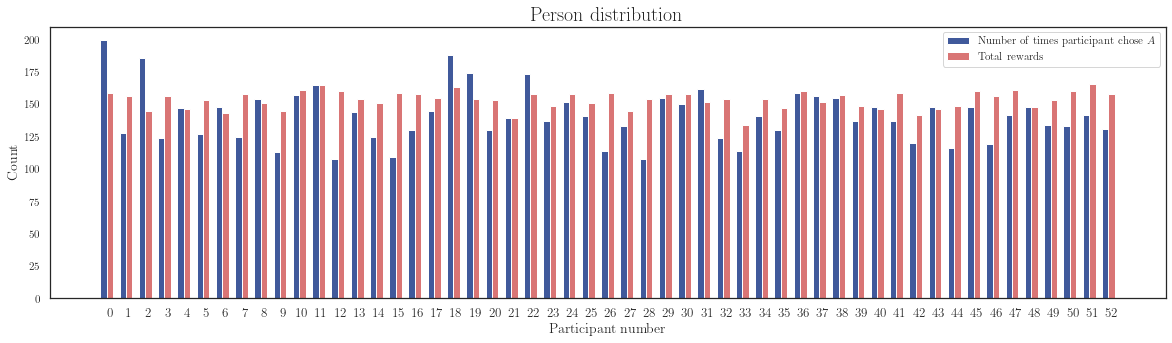

In [134]:
real_data = RealData()
real_data.explore()

### Simulated data exploration

To explore the simualted data 240 choices were simulated 100 times (representing 100 participants) with starting parameters $(\epsilon=0.35, \beta=5.5)$.

The plots show

- the mean evolution of $V^A$, 
- the mean evolution of $V^B$, and
- the mean evolution of $V^A - V^B$.

[0, 0]
(0.5, 5)
Average number of rewards: 153.35


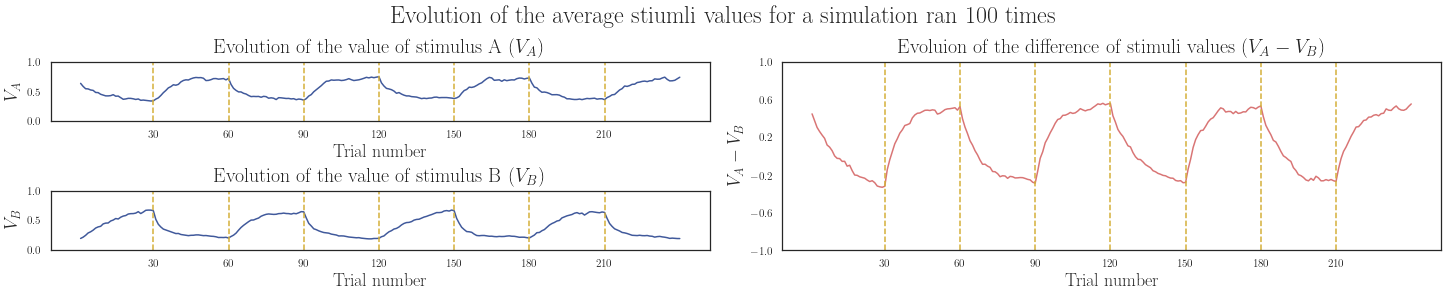

In [6]:
simulated_data = Simulation(100, (0.35, 5.5))
simulated_data.explore()

### Parameter exploration

For the parameter exploration, the values for the parameters were assigned:

- $\epsilon_{\text{values}}$: linear space of 10 elements with range $[0, 1]$, 
- $\beta_{\text{values}}$: linear space of 15 elements with range $[1, 15]$.

Then, a simulation with 100 participants was performed for each pair of parameter values. The plot represents the amount of reward for each pair.

Maximum reward corresponds to: 
  - inverse temperature: 12.0
  - learning rate: 1.0


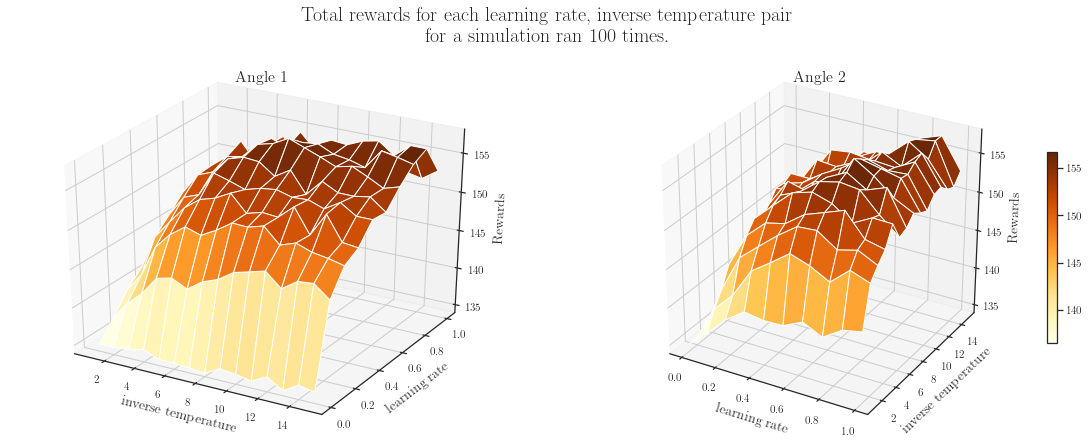

In [172]:
Behaviour.explore_parameters()

### Testing the Negative Log Likelihood function

To test the negative log likelihood the first patient should have a value of around 52 when $\epsilon = 0.4$ and $\beta = 6$. 

The NLL of the second patient was also reported

In [53]:
params = (0.4, 6)
print(f'Test for the first participant: {int(real_data.neg_log_likelihood(params, 0)) == 52}')

print(f'NNL for second participant: {real_data.neg_log_likelihood(params, 1)}')

Test for the first participant: True
NNL for second participant: 63.83424612963225


### Fitting the model to the real data

The model was fit to the real data using $\epsilon = 0.5$ and $\beta = 5$ for the starting parameters. Reporting:

- mean and standard deviation of the learning rate (LR)
- mean and standard deviation of the inverse temperature (IT)
- Overall pearson correlations between LR and IT with p-value.
- Healthy pearson correlations between LR and IT with p-value.
- MDD pearson correlations between LR and IT with p-value.
- 2-sample T-statistic and p-value of LR-healthy and LR-MDD 
- 2-sample T-statistic and p-value of IT-healthy and IT-MDD 

The plot shows the parameters estimated for each participant.

Mean Epsilon: 0.36417977113394273
Std of Epsilon: 0.12379305404434741
Mean Beta: 5.833741251163507
Std of Beta: 1.2533106045022249

Pearson correlations
  - Overall: (-0.22368507564054005, 0.11091876617802127)
  - MDD: (-0.29707701832944255, 0.231240367512403)
  - Healthy: (-0.13096284044264161, 0.46035445445594086)

T-test
Epsilon
  - T statistic: 1.3254161009076024
  - p value: 0.19105773439881502
Beta
  - T statistic: -0.663539868779145
  - p value: 0.5100328498878492


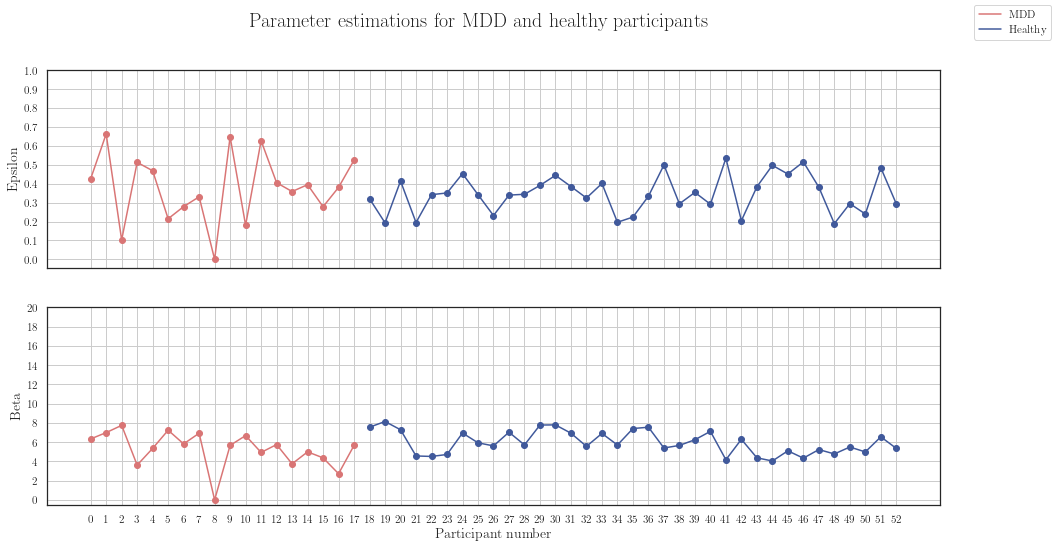

In [61]:
real_data.model_fit_stats(filter_params=True)

### Parameter recovery

For the parameter recovery 53 pairs of parameters were obtained randomly from a normal distribution. Then, 53 `Simulation` instances of 10 participants each were created. For each instance, the average best-fit parameters were computed. The pearson correlation between the starting and the best-fit parameters is reported for both the LR and the NE.

The first plot shows the distributions of the starting LE and NE.

The second plot shows the relation between the starting and the best-fit parameters for the LE and NE.

Epsilon: (0.5174485932687725, 7.25749557957221e-05)
Beta: (0.9300620371138983, 7.915762842957105e-24)


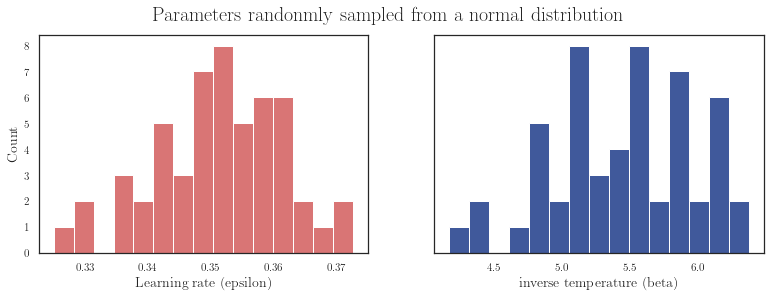

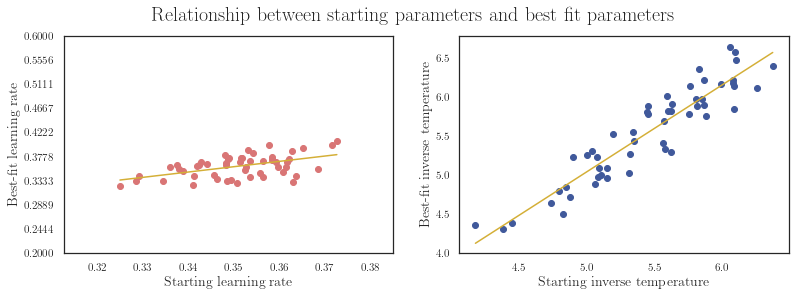

In [173]:
Behaviour.parameter_recovery(50, plot=True, save=('2.5.0', '2.5.1'))

### Alternative models

Two more models are being considered. 

#### Model 1:

The first model gets rid of the inverse temperature parameter when calculating the probability and introduces a new parameter when calculating the reinforcement learning values: a reward sensitivity (RS) parameter.

<center>
$  V_t^i = V_t^i + \epsilon + (\rho \times r_t - V_t^i) $
</center>

<center>
$P(\text{action } A | V_t) = \frac{\mathrm{exp}(V_t^A)}{\mathrm{exp}(V_t^A) + \mathrm{exp}(V_t^B)}$
</center>    
The model is fit to the real data using  $\epsilon=0.5$  and  $\rho=5.5$  for the starting parameters. 

#### Model 2:

The second model uses the same equations as model 1. However, instead of having $[0,0]$ as the initial RL values, it is set as $[0.3,1]$.

Reporting for both models:

- mean and standard deviation of the learning rate (LR)
- mean and standard deviation of the inverse temperature (NE)
- Overall pearson correlations between LR and IT with p-value.
- Healthy pearson correlations between LR and IT with p-value.
- MDD pearson correlations between LR and IT with p-value.
- 2-sample T-statistic and p-value of LR-healthy and LR-MDD
- 2-sample T-statistic and p-value of IT-healthy and IT-MDD

The plot shows the parameters estimated for each participant.

Model 1
Mean Epsilon: 0.37275081291069906
Std of Epsilon: 0.11901251898915283
Mean Rho: 5.879874621484116
Std of Rho: 1.170170944047196

Pearson correlations
  - Overall: (-0.21368528679185728, 0.14040861373650604)
  - MDD: (-0.3257507007660816, 0.18711839639553804)
  - Healthy: (-0.13067547251215372, 0.48349973555807363)

T-test
Epsilon
  - T statistic: 1.326168737150209
  - p value: 0.19119266544718536
Rho
  - T statistic: 0.3083684058904253
  - p value: 0.7591646567846637

Model 2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invali

Mean Epsilon: 0.3509244926771274
Std of Epsilon: 0.12185692240099885
Mean Beta: 6.042842649280355
Std of Beta: 1.3374159562343235

Pearson correlations
  - Overall: (-0.25691336098158324, 0.06877045592226895)
  - MDD: (-0.34445671855071813, 0.16158350386504197)
  - Healthy: (-0.13422392265871896, 0.45644899875522044)

T-test
Epsilon
  - T statistic: 1.513370123409767
  - p value: 0.1366095493772846
Beta
  - T statistic: -0.5130776263337231
  - p value: 0.6102025993331982


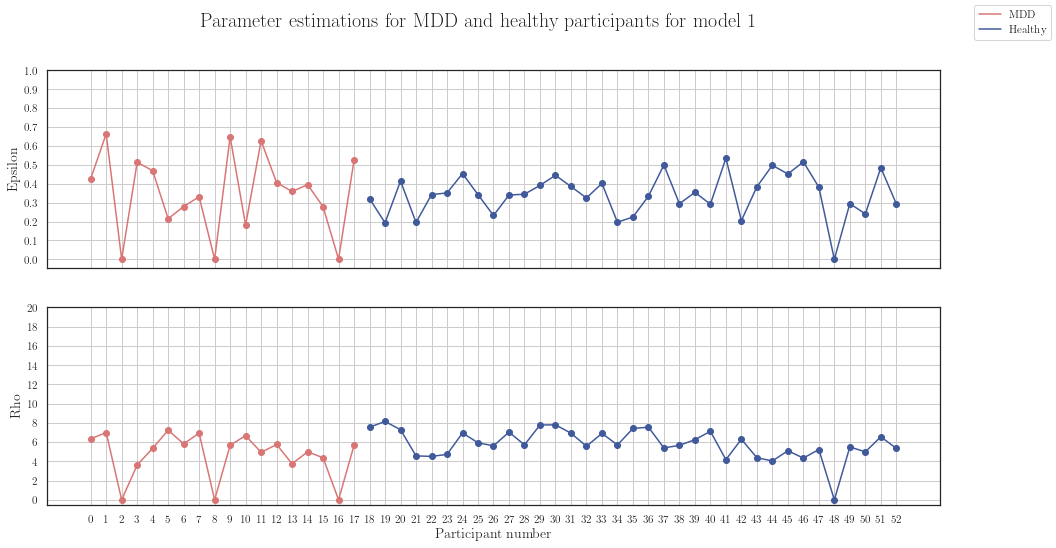

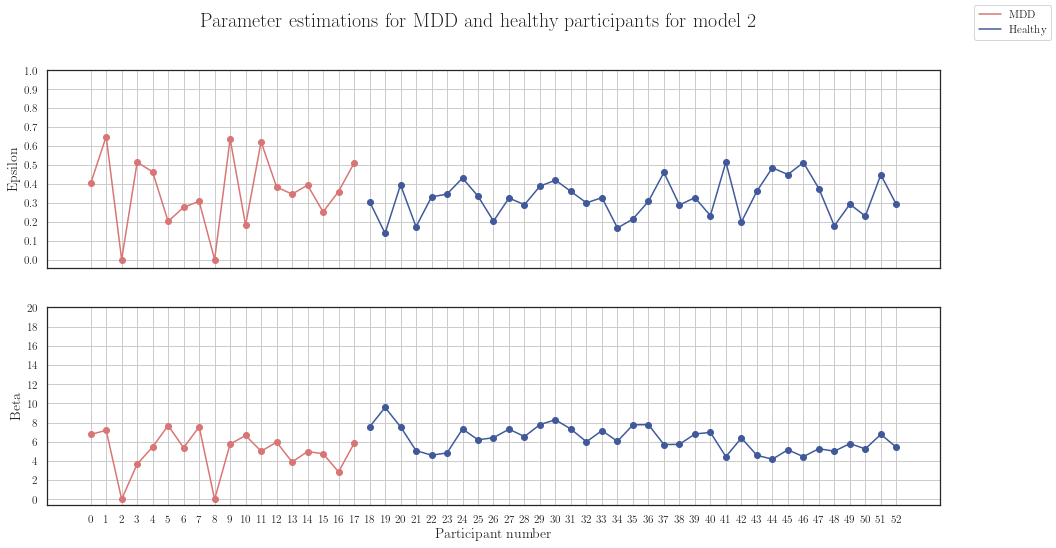

In [167]:
print('Model 1')
real_data_m1 = RealData(model=1)

m1_fit = real_data_m1.model_fit_stats(filter_params=True, title='for model 1')

print('\nModel 2')
real_data_m2 = RealData(model=2)
m2_fit = real_data_m2.model_fit_stats(filter_params=True, title='for model 2')

### Model comparison

The real data is being fit to each model. For all models: 

   - For each participant calculate the AIC and BIC scores
       - $AIC = 2 \times NLL + 2 \times p$
       - $BIC = 2 \times NLL + p \times \mathrm{log}n$
       
       where $NLL$ is the negative log likelihood, $p$ is the numbber of parameters and $n$ the number of trials.
       
   - The scores for all participants are summed.
   
Reporting the $AIC$ and $BIC$ scores for all models.

In [168]:
model_comp = Behaviour.model_comparison()

print(json.dumps(model_comp, indent=2))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invali

{
  "0": {
    "AIC": 8377.163246666241,
    "BIC": 33129.16324666624
  },
  "1": {
    "AIC": 8633.737976437646,
    "BIC": 33385.737976437646
  },
  "2": {
    "AIC": 8610.700008976464,
    "BIC": 33362.70000897646
  }
}


### Model Recovery

Model recovery is used to check the reliability of the model comparisson procedures.

For each model:
  
  - Simulate TRIALS datasets using parameters obtained from a Gaussian
  - For each trial:
    - Simulate the data using the parameters sampled
    - Find the best-fit parameters using the three different models
    - Check which one has the lowest AIC/BIC score
    
The confusion matrix shows the the ratio of the number of times a model simulated the data and the number of times the model was the best-fit model.

In [ ]:
Behaviour.model_recovery(ppts=53, trials=50)

# Drift Decision process


Decision processes can be modeled using a drife-diffusion process (see [[Smith and Ratcliff, 2014](https://www.sciencedirect.com/science/article/pii/S0166223604000220)]). When an individual is asked to make a binary choice on the basis of an available stimulus, the assumption is that evidence from the stimulus is accumulated over time and a decision is made as soon as an upper or lower boundary is reached. Which boundary is reached determines which response is given and the time required to reach it determines the response time.

To model a decision process between two hypotheses, $h^+$ and $h^-$, we use a Wienet diffusion process $W(t)$ with drift rate $v$ and variance $s^2$, simulated using
<center>
$W(t+dt) = W(t) + v \times dt + s \times \eta$
</center>

- if $W(t) < 0$, a decision in favour of $h^-$ is made, 
- if $W(t) > a$, a decision in favour of $h^+$ is made, where $a$ is the separation of the boundaries.

$\eta$ represents a Gaussian noise $\mathcal{N}(0, dt)$.

When there is no bias, $W(0) = \frac{a}{2}$. When there is bias, $W(0)$ is moved linearly up (if bias $>$ 0) when there is bias towards $h^+$, or down (if bias $<$ 0) when there is bias towards $h^-$

In [17]:
DECISION_INPUTS = namedtuple('Inputs', 'v, a, s, z, dt, timesteps, reps', 
                             defaults=(0.03, 0.12, 0.04, None, 0.001, 2000, 100))


class Decision(object):
    """ Class to model and experimetn with drift difusion decision models.
    """
    ### Parameters for plotting
    plot_params = {
        'label_size': 14,
        'title_size': 20,
        'subplot_size': 16,
        'blue': '#40599B',
        'red': '#D97575',
        'gold': '#d4af37',
    } 
    
    def __init__(self, params, bias=0):
        """ Initialisation
        :param: params (namedtuple)
        - v: mean drift rate
        - a: separation of the boundaries
        - s: standard deviation
        - z: starting point (a/2 if bias=0)
        - dt: to discretize time
        - timesteps: timesteps to perform
        - reps: times to repeat the simulation
        """
        
        # Random seed for replicability
        np.random.seed(1234)
        
        # Set the appropiate starting point, taking the bias
        # into consideration.
        # If bias=0 z will not be changed.
        self.params = params._replace(z = 2.0 * params.a / 3)
        # Perform the simulation
        (self.simulations, self.decisions, 
         self.h_plus_times, self.h_min_times) = self.simulate()
        
        # Get all the timesteps
        self.times = np.linspace(0, self.params.dt * self.params.timesteps, 
                                      num=self.params.timesteps)
        # For plotting
        self.time_ticks = np.linspace(0, self.params.dt * self.params.timesteps, 
                                      num=int(self.params.timesteps / 100) + 1)
            
    def simulate(self):
        """ Perform the simulation using a Wiener decision process.
        Decided between two hypothesis, h+ and h-.
        :return: - simulations: list of Ws
                 - decisions: decision for all simulations
                 - h_plus_times: times when an h+ decision was made
                 - h_min_times: times when an h- decision was made.
        """
        # Initialisations
        simulations, decisions = [], []
        h_plus_times, h_min_times = [], []
        
        # For all the required repetitions
        for _ in range(self.params.reps):
            # Get the starting W
            W = self.params.z
            Ws = []
            # Decision state
            decided = False
            # For all timesteps
            for t in range(self.params.timesteps):
                # Set Gausian noise
                noise = np.random.normal(0, np.sqrt(self.params.dt))
                # If W > a h+ is decided
                if W > self.params.a:
                    # If the decision is new, record the time.
                    if not decided:
                        h_plus_times.append(t)
                        decided = True
                # Same as above but for h-
                elif W < 0:
                    if not decided:
                        h_min_times.append(t)
                        decided = True
                # If no decision has been reached, update W
                else:
                    W = W + self.params.v * self.params.dt + self.params.s * noise
                Ws.append(W)
                
            # Append Ws to the list of all simulations
            simulations.append(Ws)
            # If h+ is the winner, record it
            if W > self.params.a:
                decisions.append(1)
            # If h- is the winner, record it
            elif W < 0:
                decisions.append(-1)
            # If no winner, record it.
            else:
                decisions.append(0)
        return simulations, decisions, h_plus_times, h_min_times
    
    def plot(self, paths=True, distr_plot=True, distr_stats=True, 
             title='', save=(False, False)):
        """ Plot example decision paths and the decision distributions
        """
        if paths:
            self._plot_example_paths(title=title, save=save[0])
        
        self._distributions(title=title, stats=distr_stats, plot=distr_plot, 
                            save=save[1])
    
    def _plot_example_paths(self, n=10, title='', save=False):
        """ Plot n example paths
        """
        fig = plt.figure(figsize=(20,5))
        choices = np.random.choice(range(len(self.simulations)), n, replace=False)
    
        plt.plot(self.times, [self.params.a] * len(self.times), 
                 color=Decision.plot_params['blue'], linestyle='--', 
                 label='$h_+$ threshold')
        plt.plot(self.times, 0 * self.times,  
                 color=Decision.plot_params['red'], linestyle='--', 
                 label='$h_-$ threshold')
        
        for i in choices:
            plt.plot(self.times, self.simulations[i])

        plt.xlabel('Time (ms)', fontsize=Decision.plot_params['label_size'])
        plt.ylabel('W', fontsize=Decision.plot_params['label_size'])
        plt.title(f'{n} random examples of a Wiener drift decision process ' + title, 
                  fontsize=Decision.plot_params['title_size'])   
        plt.legend(prop={'size': Decision.plot_params['subplot_size']})
        
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
        
    def _distributions(self, title='', stats=True, plot=True, save=False):
        """ Plot the decision distributions
        """
        if plot:
            fig, axs = plt.subplots(1, 3, figsize=(20,4))
            
        num_plus = len(self.h_plus_times)
        num_min = len(self.h_min_times)
        num_none = self.params.reps - (num_plus + num_min)
        
        if stats:
            print(f'Number of h+: {num_plus}; {round(num_plus / self.params.reps * 100, 2)}%')
            print(f'Number of undecided: {num_none}; {round(num_none / self.params.reps * 100, 2)}%')
            print(f'Number of h-: {num_min}; {round(num_min / self.params.reps * 100, 2)}%')
        
        if plot:
            axs[0].bar(['$h_-$', 'undecided', '$h_+$'], [num_min, num_none, num_plus], 
                       color=Decision.plot_params['gold'])
            axs[0].set_title('Distribution of decisions', 
                             fontsize=Decision.plot_params['subplot_size'])
            axs[1].hist(self.h_plus_times, color=Decision.plot_params['blue'], bins=10)
            axs[1].set_title('Distribution of times to decide $h_+$.', 
                             fontsize=Decision.plot_params['subplot_size'])
            axs[1].set_xlabel('Time (ms)', fontsize=Decision.plot_params['label_size'])
            axs[2].hist(self.h_min_times, color=Decision.plot_params['red'], bins=10)
            axs[2].set_title('Distribution of times to decide $h_-$.', fontsize=Decision.plot_params['subplot_size'])
            axs[2].set_xlabel('Time (ms)', fontsize=Decision.plot_params['label_size'])
                             
            if save:
                plt.savefig(f'figures/{save}.pdf', format='pdf')

    @staticmethod    
    def explore_parameters(inputs):
        """ Explore different parameter setting
        :param: list of namedtuples containing the inputs
        """
        for i in inputs:
            params = DECISION_INPUTS(v=i[0], a=i[1])
            dd = Decision(params)
            print(f'\nInputs: v: {i[0]}, a: {i[1]}')
            dd.plot(distr_plot=True, distr_stats=True, 
                    title=f'for $v={i[0]}$ and $a={i[1]}$', 
                    save=(False, f'1-params-{i[0]}-{i[1]}'))
    
   
        
        

###  Initial simulations

Simulate various decision process using $v=0.03$, $a=0.12$, $s0.05$, $z=0.015$, $dt=0.001$, with 2000 steps.

Plotting

- 10 example paths
- The response distributions ($h^+$, $h^-$ and overall histograms)

Number of h+: 64; 64.0%
Number of undecided: 26; 26.0%
Number of h-: 10; 10.0%


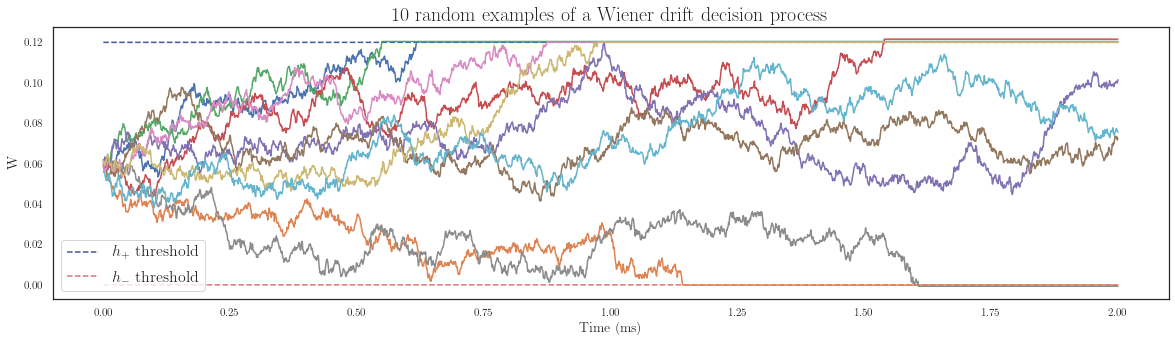

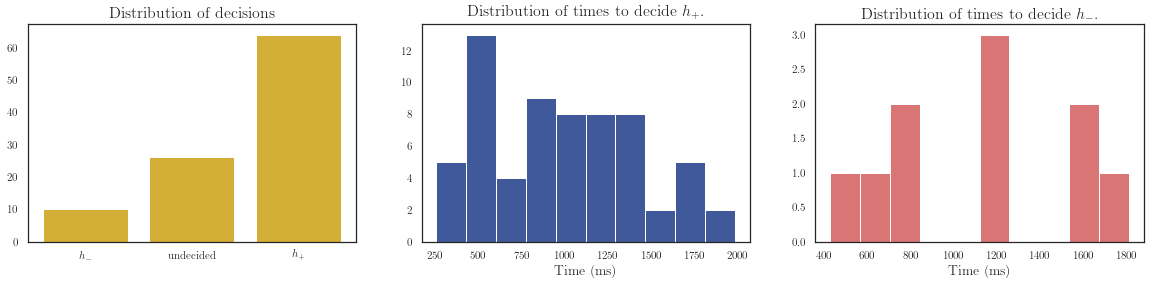

In [14]:
dd = Decision(DECISION_INPUTS())
dd.plot(save=('1-paths', '1-distr'))

### Parameter exploration

Several parameters are being explored

- original parameters: $(v=0.03, a=0.12)$
    
- doubling $v$ but leaving $a$ the same: $(v=0.06, a=0.12)$
    
- leaving $v$ the same and halving $a$: $(v=0.03, a=0.06)$
    
- doubling $v$ and halving $a$: $(v=0.06, a=0.06)$
 
- setting $v$ to 0 and halving $a$: $(v=0.0, a=0.06)$


Inputs: v: 0.03, a: 0.12
Number of h+: 64; 64.0%
Number of undecided: 26; 26.0%
Number of h-: 10; 10.0%

Inputs: v: 0.06, a: 0.12
Number of h+: 91; 91.0%
Number of undecided: 9; 9.0%
Number of h-: 0; 0.0%

Inputs: v: 0.03, a: 0.06
Number of h+: 80; 80.0%
Number of undecided: 0; 0.0%
Number of h-: 20; 20.0%

Inputs: v: 0.06, a: 0.06
Number of h+: 90; 90.0%
Number of undecided: 1; 1.0%
Number of h-: 9; 9.0%

Inputs: v: 0, a: 0.06
Number of h+: 56; 56.0%
Number of undecided: 3; 3.0%
Number of h-: 41; 41.0%


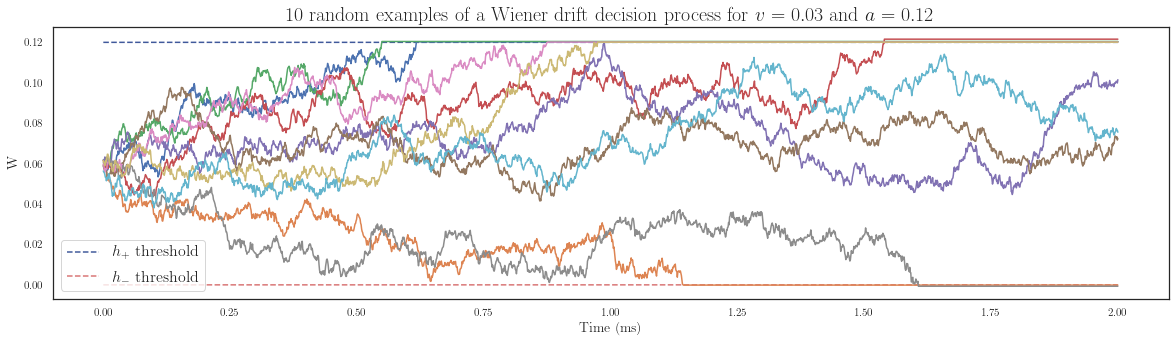

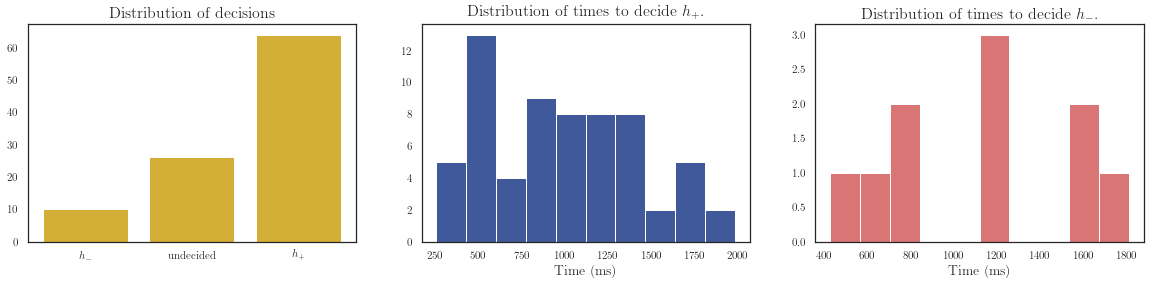

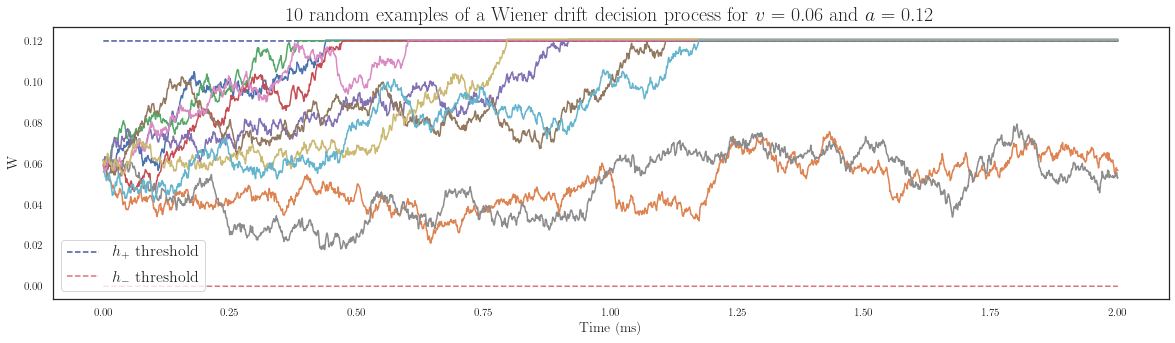

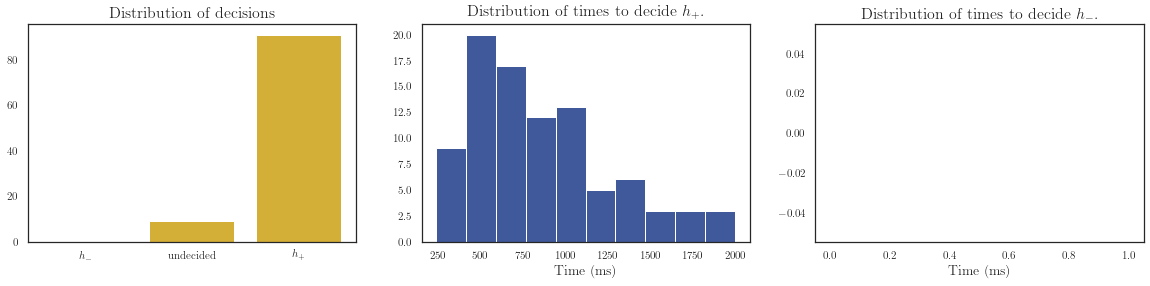

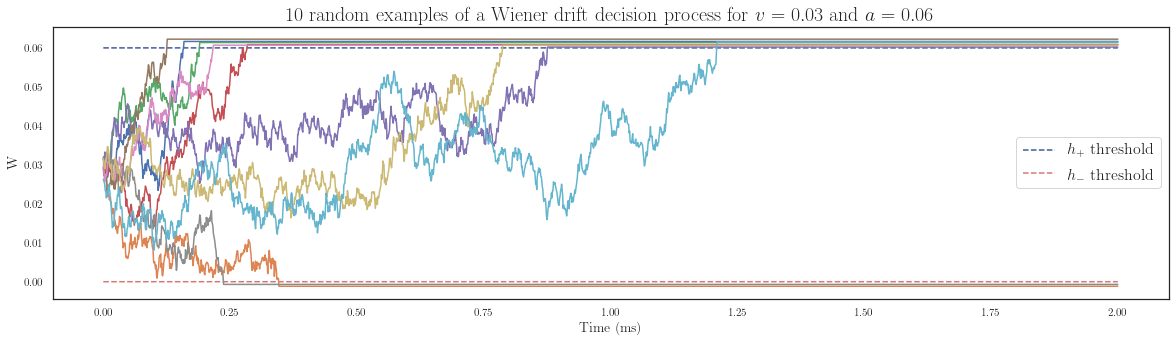

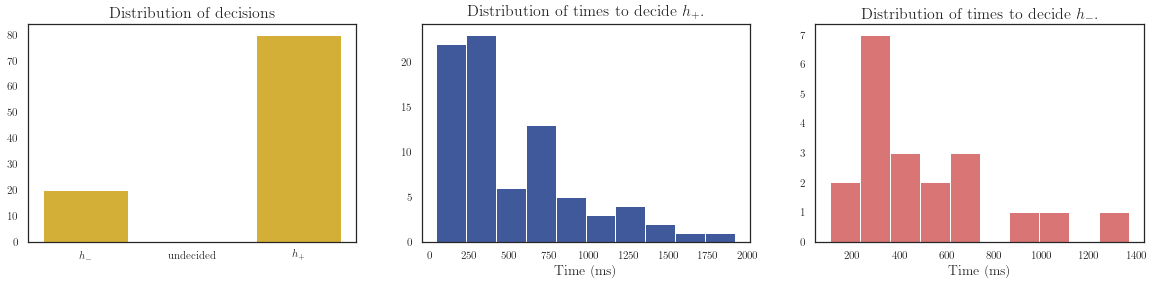

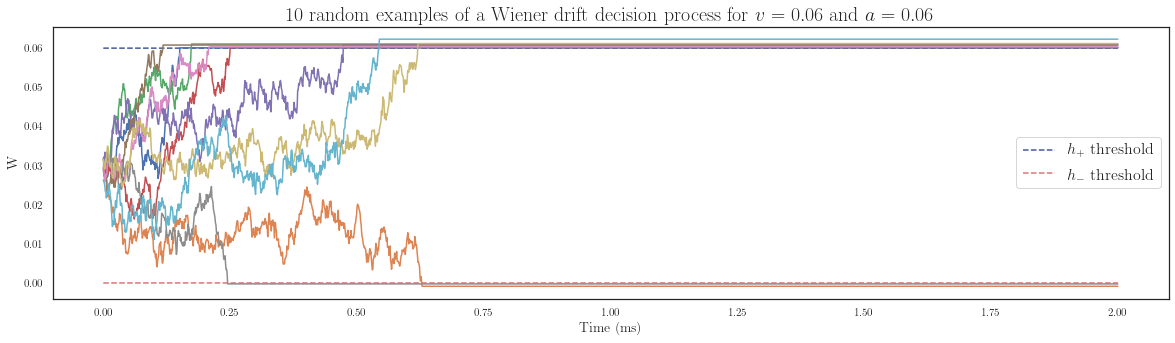

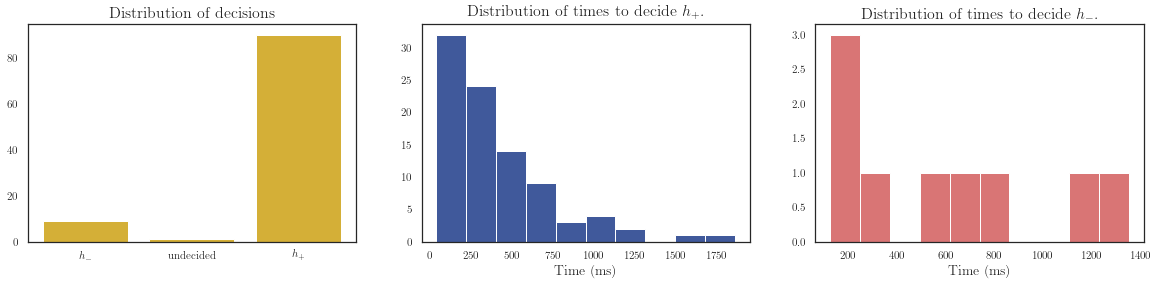

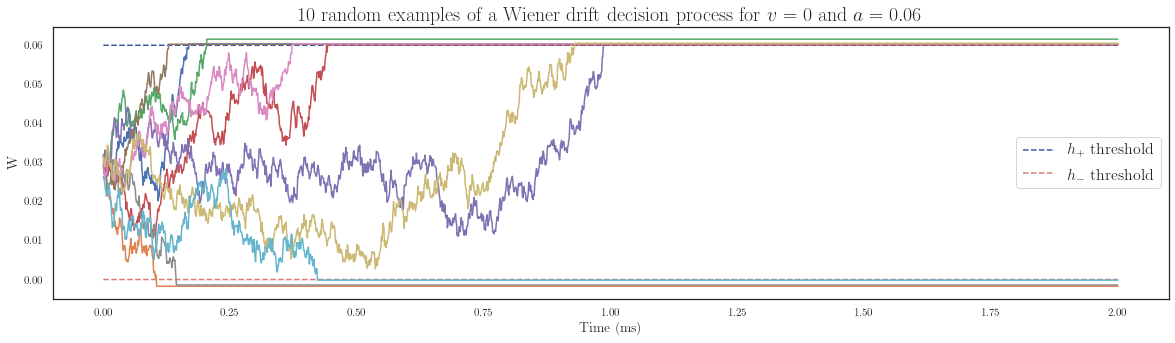

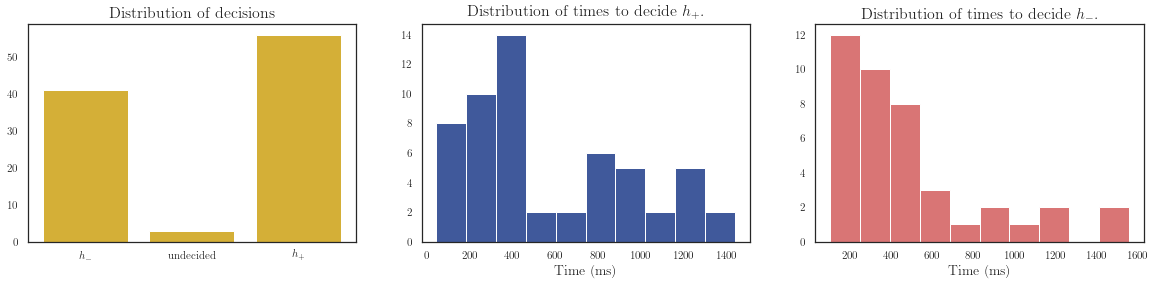

In [16]:
Decision.explore_parameters([(0.03, 0.12), (0.06, 0.12), (0.03, 0.06), (0.06, 0.06), (0, 0.06)])

### Adding bias

Adding a bias such that the prior of $h^+$ is twice as likely as the prior of $h^-$. 

Number of h+: 78; 78.0%
Number of undecided: 20; 20.0%
Number of h-: 2; 2.0%


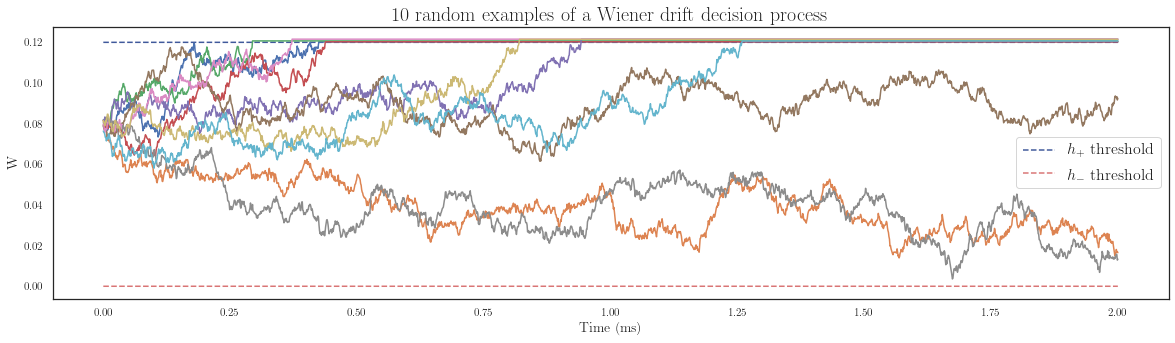

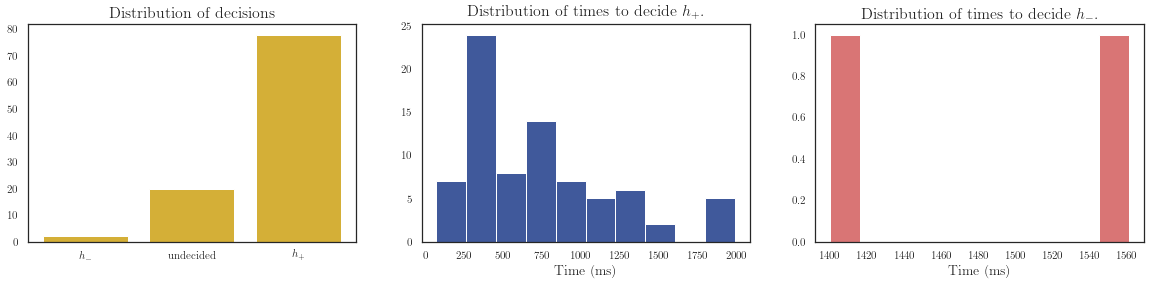

In [19]:
dd = Decision(DECISION_INPUTS(), bias=0.5)
dd.plot(save=('1-bias-0', '1-bias-1'))